# Importing modules and basic settings

In [1]:
#Did this because import error in next line, weird cuz i did add it to my env
!pip install scFates

In [2]:
#Added due to error for missing module below
!pip install -U loompy

  Using cached loompy-3.0.7-py3-none-any.whl
  Using cached numpy_groupies-0.9.20-py3-none-any.whl (25 kB)


In [2]:
!pip3 install scanpy

In [1]:
import scanpy as sc
import scFates as scf
import warnings
warnings.filterwarnings("ignore")

adata = sc.read('hgForebrainGlut.loom', backup_url='http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom')
adata.var_names_make_unique()
sc.set_figure_params()
#Fixed Scanpy Module Not Found with pip3 install --upgrade --force-reinstall ..... on terminal

In [2]:
import sys
sc.settings.verbosity = 3
sc.settings.logfile = sys.stdout

# Pre-processing

In [3]:
sc.pp.filter_genes(adata,min_cells=3)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata,base=10)
sc.pp.highly_variable_genes(adata)

filtered out 18081 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [4]:
adata.raw=adata

In [5]:
adata=adata[:,adata.var.highly_variable]
sc.pp.scale(adata)
sc.pp.pca(adata)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


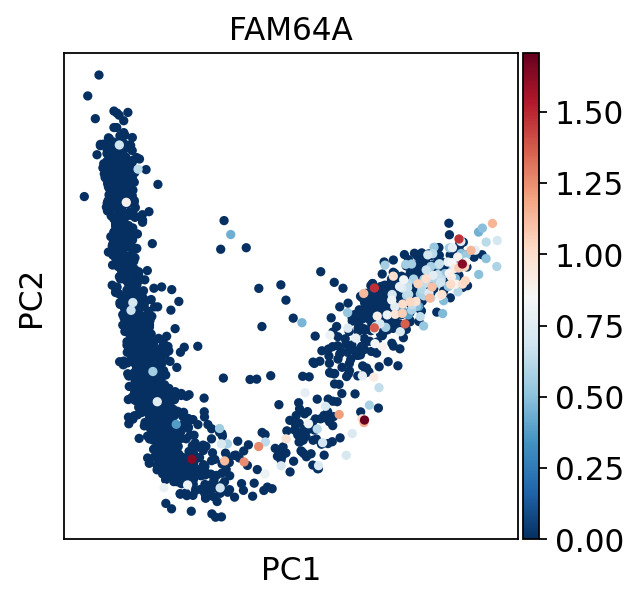

In [6]:
sc.pl.pca(adata,color="FAM64A",cmap="RdBu_r")

# Learn curve using ElPiGraph algorithm

In [7]:
scf.tl.curve(adata,Nodes=30,use_rep="X_pca",ndims_rep=2,)

inferring a principal curve --> parameters used 
    30 principal points, mu = 0.1, lambda = 0.01
    finished (0:00:00) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] hard assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


## Plotting the tree

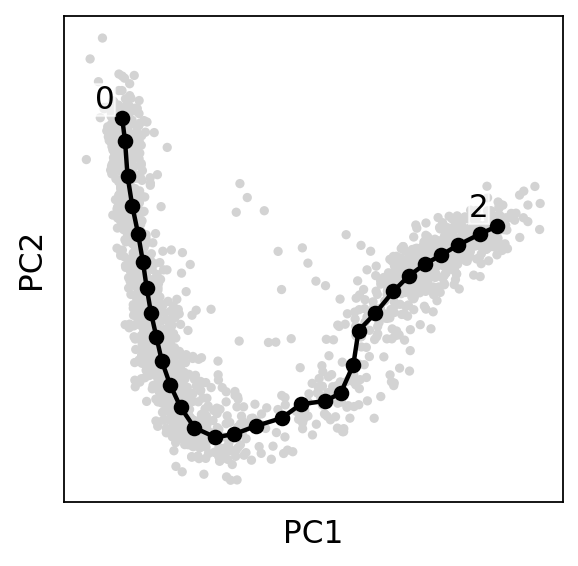

In [8]:
scf.pl.graph(adata,basis="pca")

## Showing hard assignment of cells

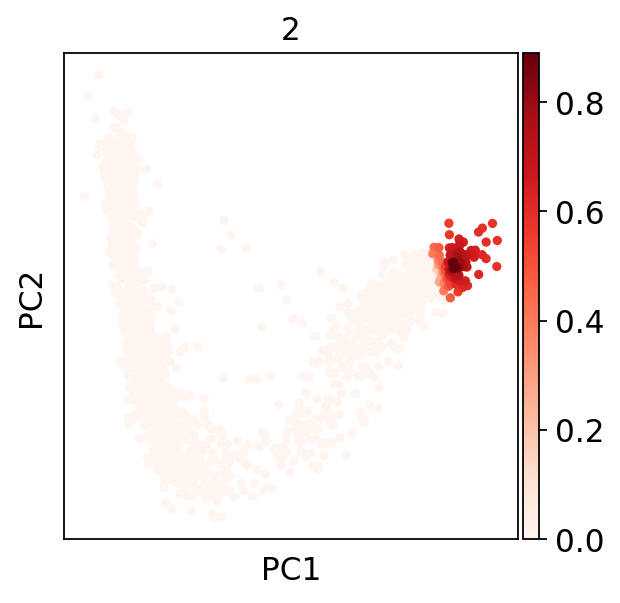

In [9]:
sc.pl.pca(sc.AnnData(adata.obsm["X_R"],obsm=adata.obsm),color="2",cmap="Reds")

## Hard versus soft assignment

In [10]:
scf.tl.convert_to_soft(adata,1,1000)

Converting R into soft assignment matrix
    finished (0:00:00) --> updated 
    .obsm['X_R'] converted soft assignment of cells to principal points.
    .uns['graph']['F'] coordinates of principal points in representation space.


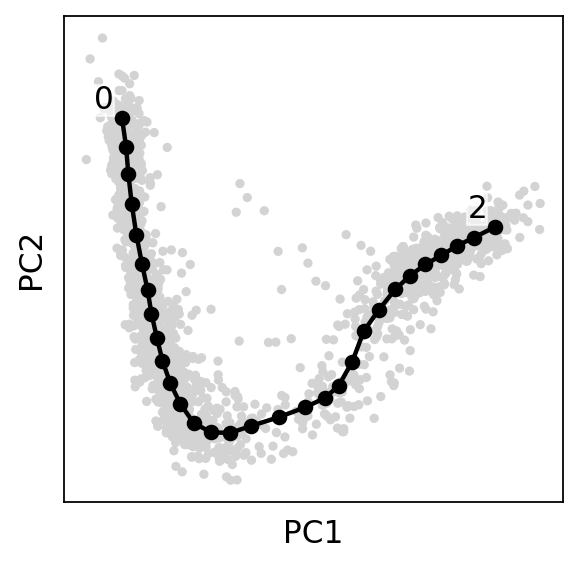

In [11]:
scf.pl.graph(adata,basis="pca")

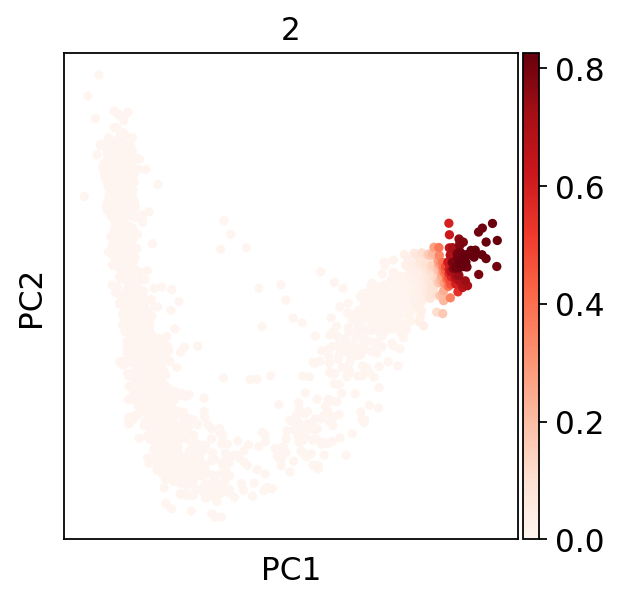

In [12]:
sc.pl.pca(sc.AnnData(adata.obsm["X_R"],obsm=adata.obsm),color="2",cmap="Reds")

# Selecting a root and computing pseudotime

Using FAM64A marker, we can confidently tell that the tip 1 is the root.

In [13]:
scf.tl.root(adata,"FAM64A")

automatic root selection using FAM64A values
node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


Here we are running 100 mappings to account for uncertainty, the pseudotime saved in obs will be the mean of all computed pseudotimes:

In [14]:
scf.tl.pseudotime(adata,n_jobs=20,n_map=100,seed=42)

projecting cells onto the principal graph
    mappings:   0%|                                                                         | 0/100 [00:00<?, ?it/s]

Unable to determine R library path: Command '('/vol/mbconda/imarais/miniconda3/envs/scfates/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/vol/mbconda/imarais/miniconda3/envs/scfates/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/vol/mbconda/imarais/miniconda3/envs/scfates/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/vol/mbconda/imarais/miniconda3/envs/scfates/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/vol/mbconda/imarais/miniconda3/envs/scfates/lib/R/bin/Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 2.
Unable to determine R library path: Command '('/vo

    mappings: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.80it/s]
    finished (0:00:18) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


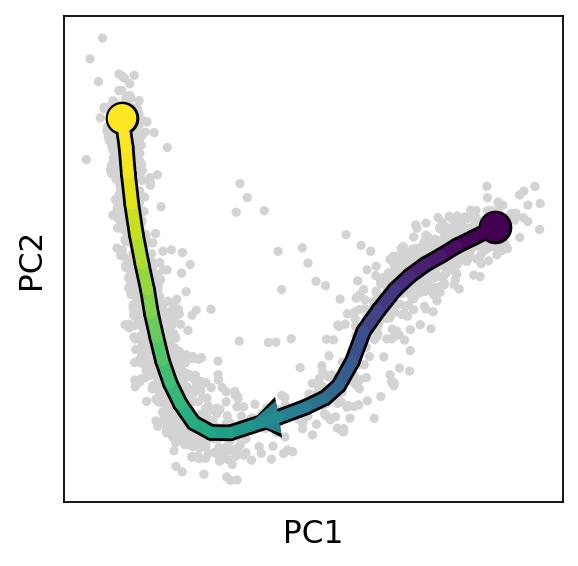

In [15]:
scf.pl.trajectory(adata,basis="pca",arrows=True,arrow_offset=3)

In [16]:
adata=adata.raw.to_adata()

# Linearity deviation assessment

In order to verify that the trajectory we are seeing is not the result of a lienar mixture of two population (caused by doublets), we perform the following test:

Estimation of deviation from linearity
    cells on the bridge: 100%|███████████████████████████████████████████████████| 984/984 [00:01<00:00, 654.86it/s]


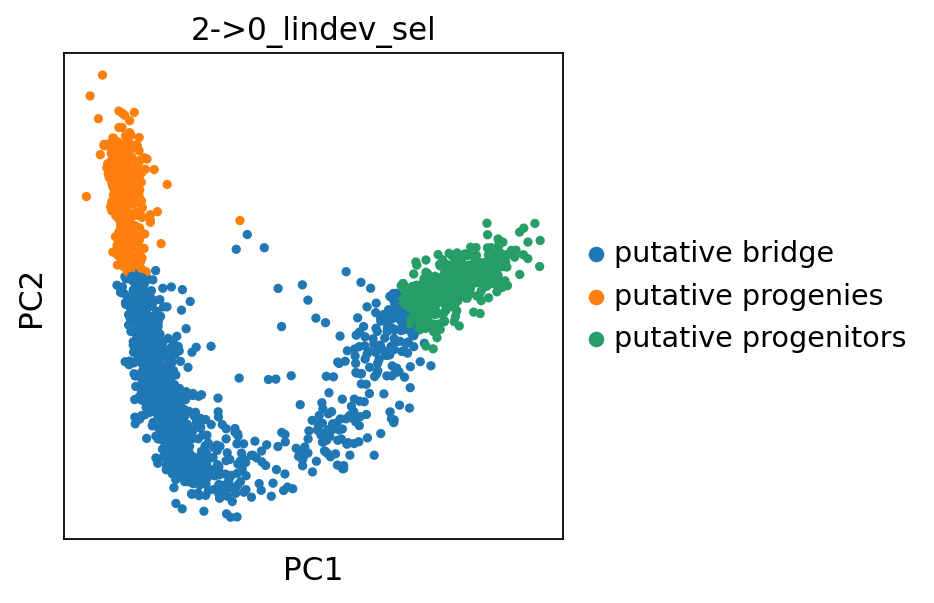

    finished (0:00:02) --> added 
    .var['2->0_rss'], pearson residuals of the linear fit.
    .obs['2->0_lindev_sel'], cell selections used for the test.


In [17]:
scf.tl.linearity_deviation(adata,start_milestone="2",end_milestone="0",n_jobs=20,plot=True,basis="pca")
#start milestone use to be 1 but then it gave a key error so changed it to 2

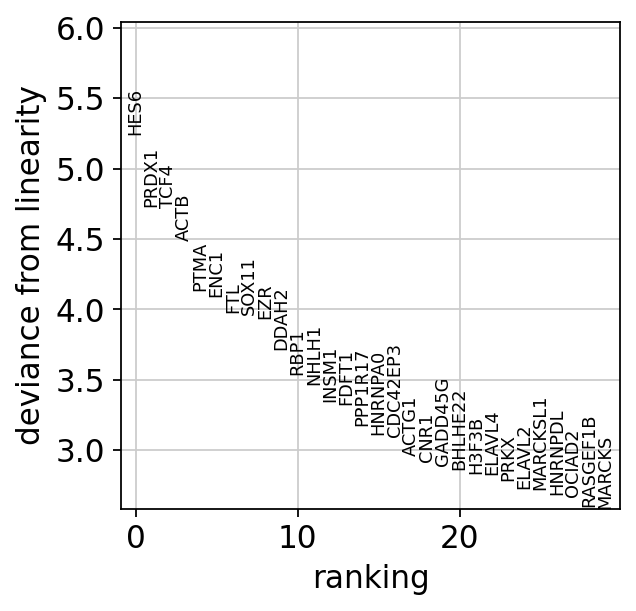

In [18]:
scf.pl.linearity_deviation(adata,start_milestone="2",end_milestone="0")
#start milestone use to be 1 but then it gave a key error so changed it to 2

We have markers that highly deviate from linearity, most of which are biologically relevant. We can confidently say that this is a developmental bridge.

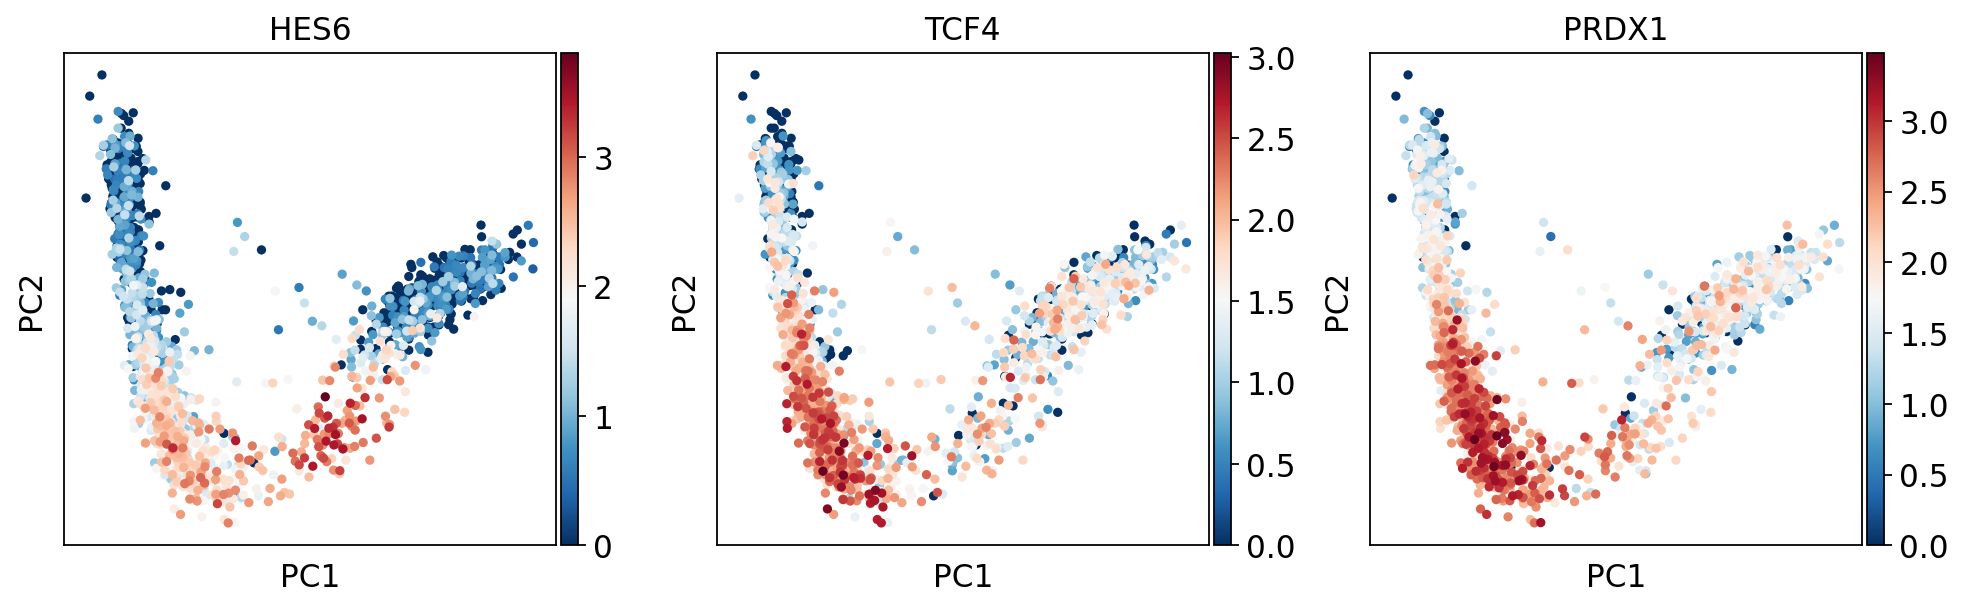

In [19]:
sc.pl.pca(adata,color=["HES6","TCF4","PRDX1"],cmap="RdBu_r")

In [20]:
#save_file = 'data/results/scfates_test.h5ad'
#adata.write_h5ad(save_file)

# Significantly changing feature along pseudotime test

In [21]:
scf.tl.test_association(adata,n_jobs=20)

test features for association with the trajectory
    single mapping : 100%|███████████████████████████████████████████████████| 14657/14657 [01:58<00:00, 123.35it/s]
    found 140 significant features (0:01:58) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


We can change the amplitude parameter to get more significant genes, this can be done without redoing all the tests (reapply_filters parameter)

reapplied filters, 590 significant features


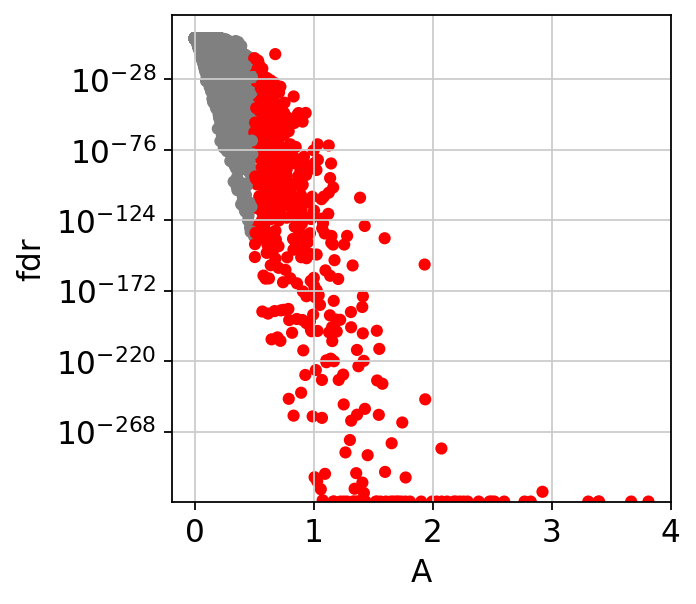

In [22]:
scf.tl.test_association(adata,reapply_filters=True,A_cut=.5)
scf.pl.test_association(adata)

# Fitting & clustering significant features

In [23]:
scf.tl.fit(adata,n_jobs=20)

fit features associated with the trajectory
    single mapping : 100%|████████████████████████████████████████████████████████| 590/590 [00:10<00:00, 58.42it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:10) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


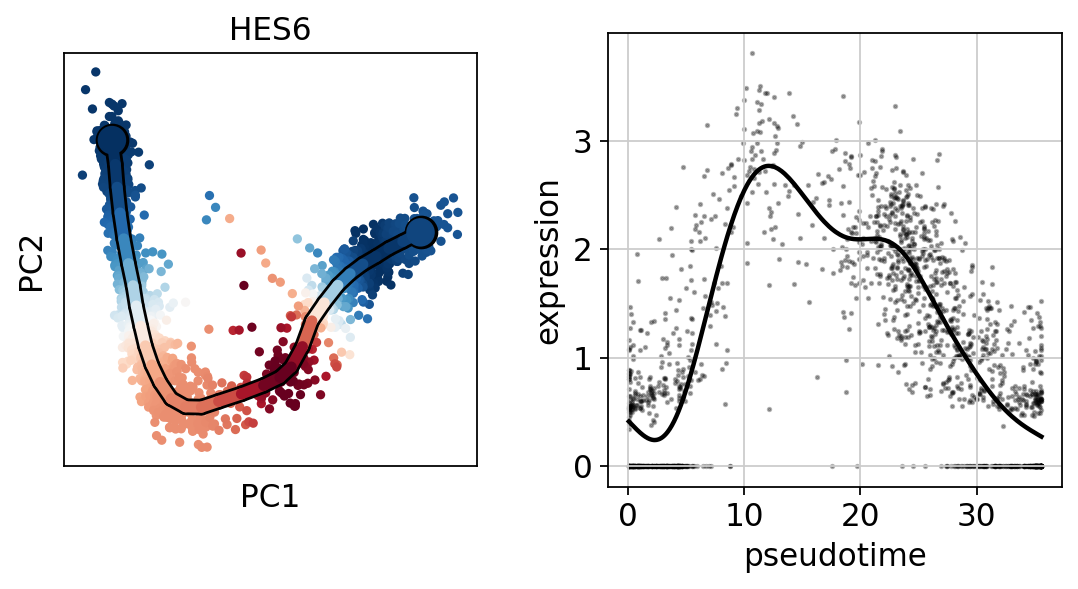

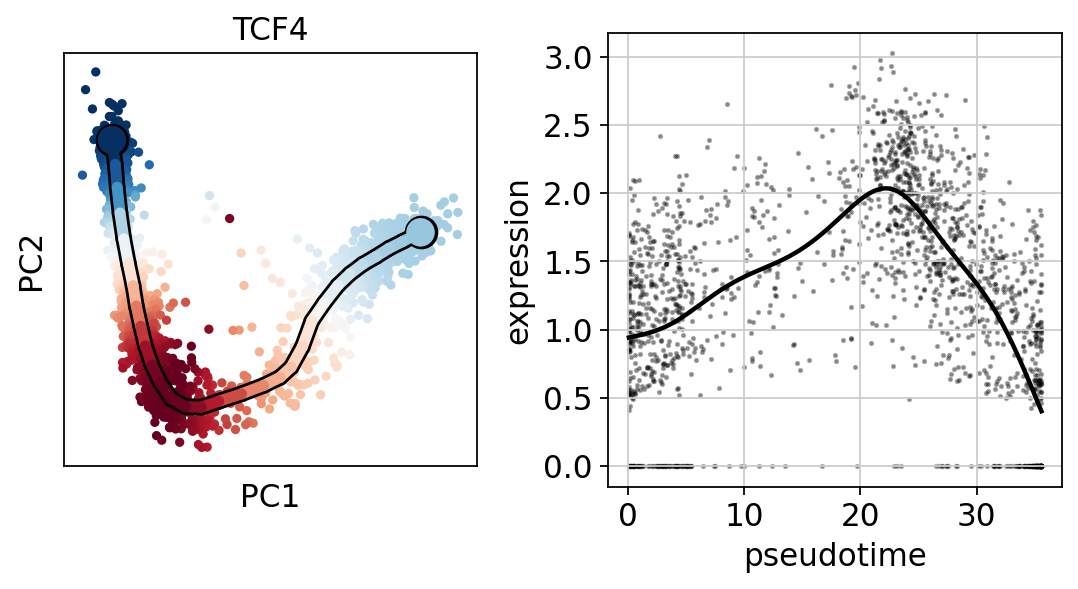

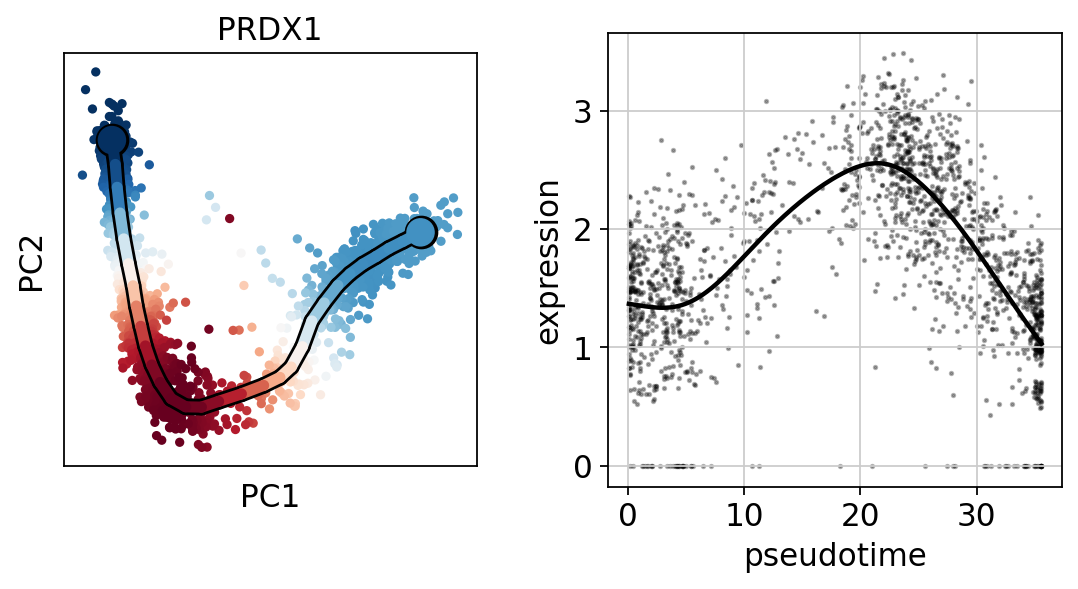

In [24]:
scf.pl.single_trend(adata,"HES6",basis="pca",color_exp="k")
scf.pl.single_trend(adata,"TCF4",basis="pca",color_exp="k")
scf.pl.single_trend(adata,"PRDX1",basis="pca",color_exp="k")

In [25]:
#Added python magic to fix knn error
!pip install python-magic

In [26]:
import magic

In [31]:
#,knn=100 was removed to see if it works CHECK WITH JULIAN , metric="correlation"
scf.tl.cluster(adata)

Clustering features using fitted layer
computing PCA
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
    finished (0:00:03) --> added 
    .var['cluters'] identified modules.


In [ ]:
#.var['fit_clusters'], cluster assignments for features.
#.uns['fit_clusters'], parameters and modularity of the clustering.
# These lines are not see in previous cell so maybe knn is important, so should i do something with the magic and python conflicts

In [37]:
adata.var

,Accession,Chromosome,End,Start,Strand,n_cells,highly_variable,means,dispersions,dispersions_norm,2->0_rss,p_val,A,fdr,st,signi,cluters
Gene,,,,,,,,,,,,,,,,,
HES4,ENSG00000188290,1,935552,934342,-,957,True,0.906923,1.160743,2.619515,-0.937426,9.430838e-202,1.315027,1.382278e-197,1,True,0
ENO1,ENSG00000074800,1,8939308,8921061,-,1457,True,1.355802,0.914609,1.121785,-0.187370,4.937094e-168,1.001629,7.236298e-164,1,True,0
CAMK2N1,ENSG00000162545,1,20812713,20808884,-,952,False,0.671054,0.305986,0.046220,-0.523550,6.381876e-57,0.519705,9.353915e-53,1,True,2
MARCKSL1,ENSG00000175130,1,32801980,32799433,-,1717,False,3.045272,1.376779,0.238341,2.718086,1.458828e-319,1.075663,2.138204e-315,1,True,6
GRIK3,ENSG00000163873,1,37499730,37261128,-,212,True,0.159702,0.555136,2.190657,-3.873521,5.215983e-191,0.568810,7.645066e-187,1,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCEAL2,ENSG00000184905,X,101382683,101380660,+,996,True,0.724567,0.454884,0.545877,-1.092507,5.395283e-44,0.585023,7.907867e-40,1,True,2
WBP5,ENSG00000185222,X,102613397,102611373,+,1091,False,0.812127,0.402906,0.371453,-0.431959,8.124847e-60,0.624817,1.190859e-55,1,True,0
NGFRAP1,ENSG00000166681,X,102633005,102631268,+,1690,False,2.035757,0.404189,-0.666511,-0.539636,2.510023e-31,0.543049,3.678940e-27,1,True,6


In [32]:
adata.var.cluters.unique()

['0', '2', '6', '8', '4', '5', '3', '1', '7']
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']

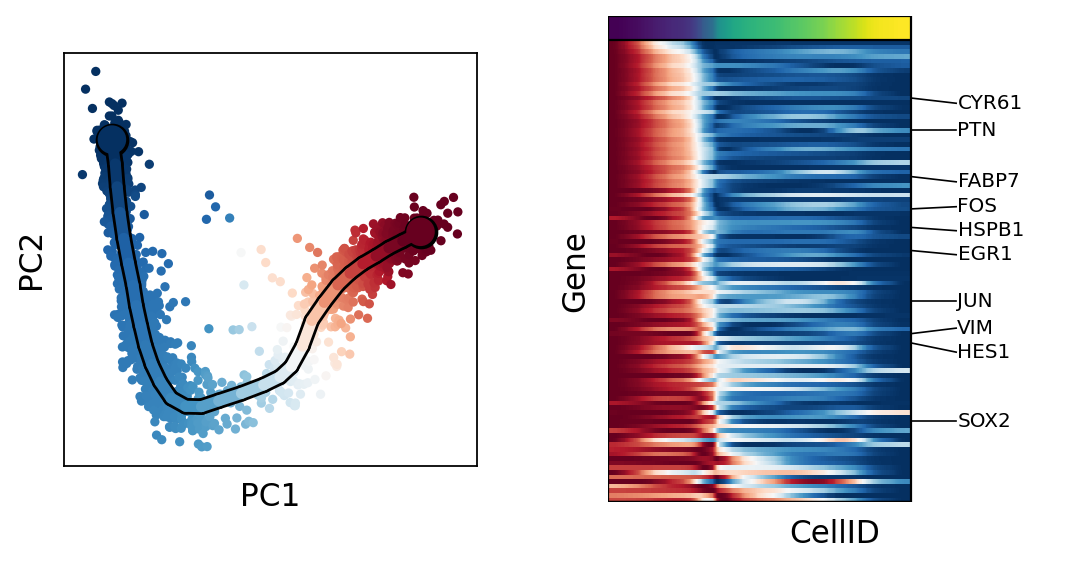

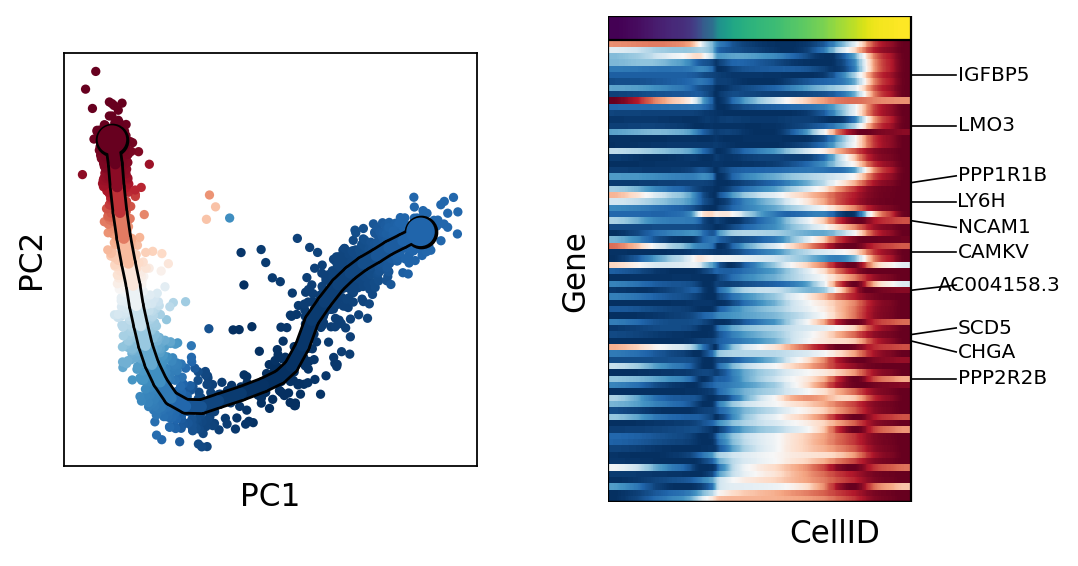

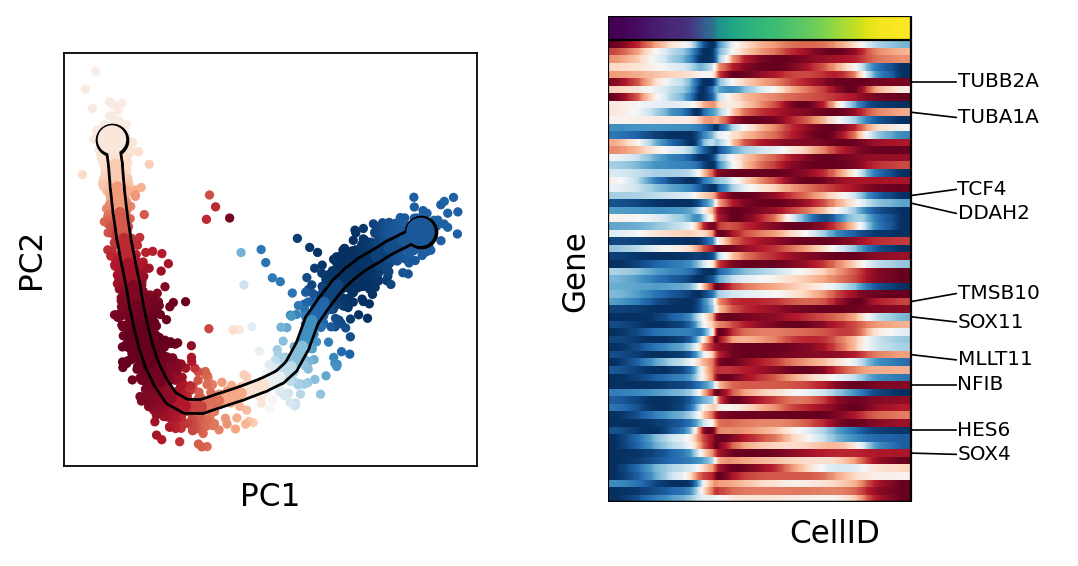

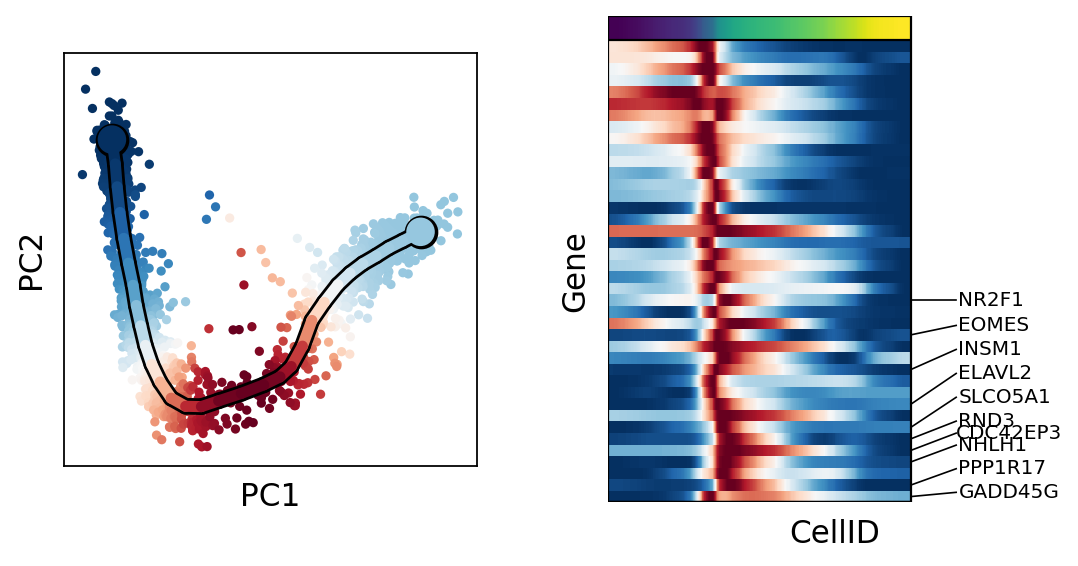

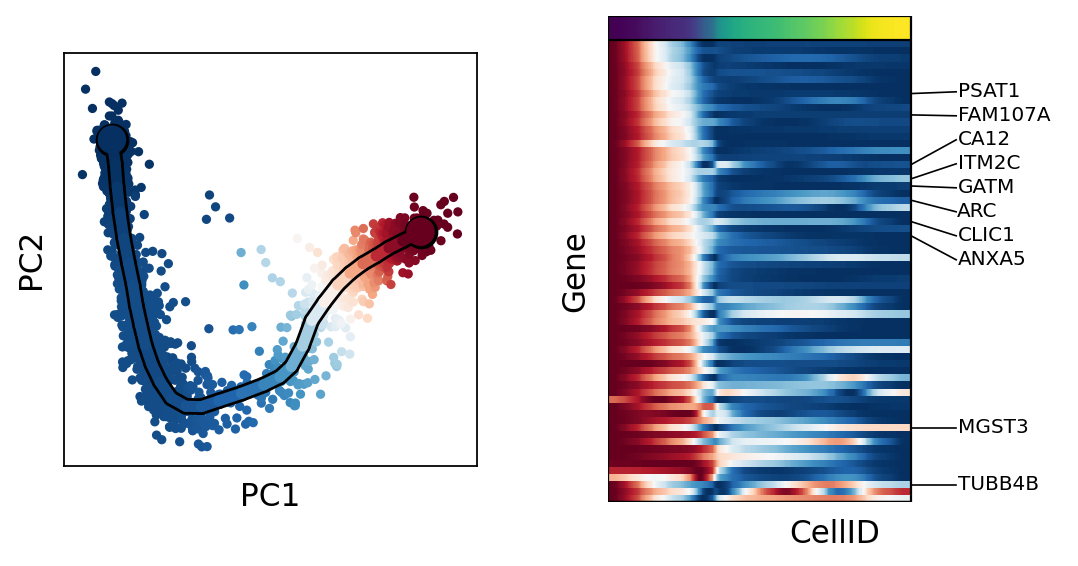

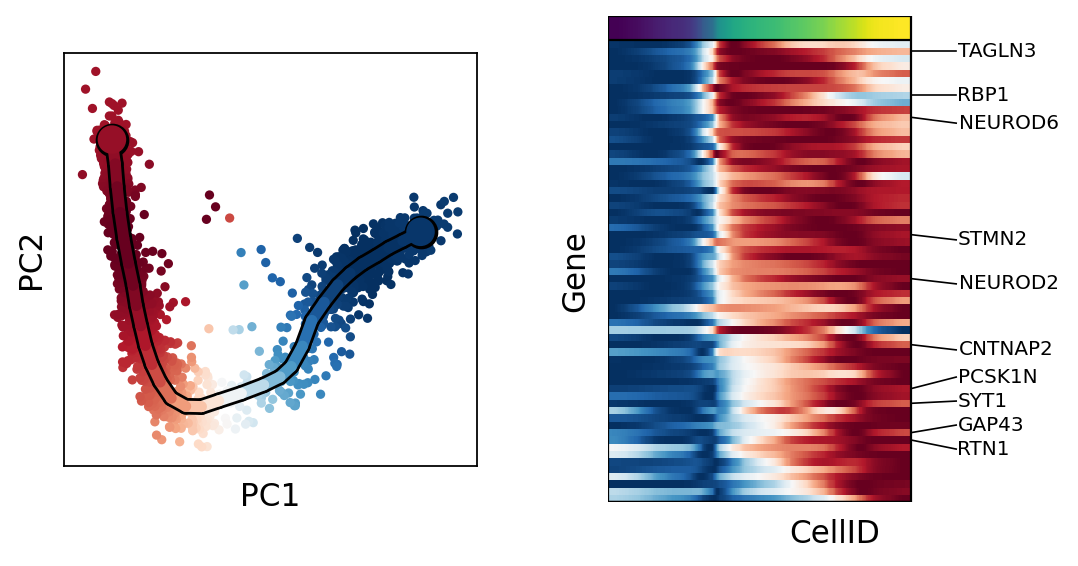

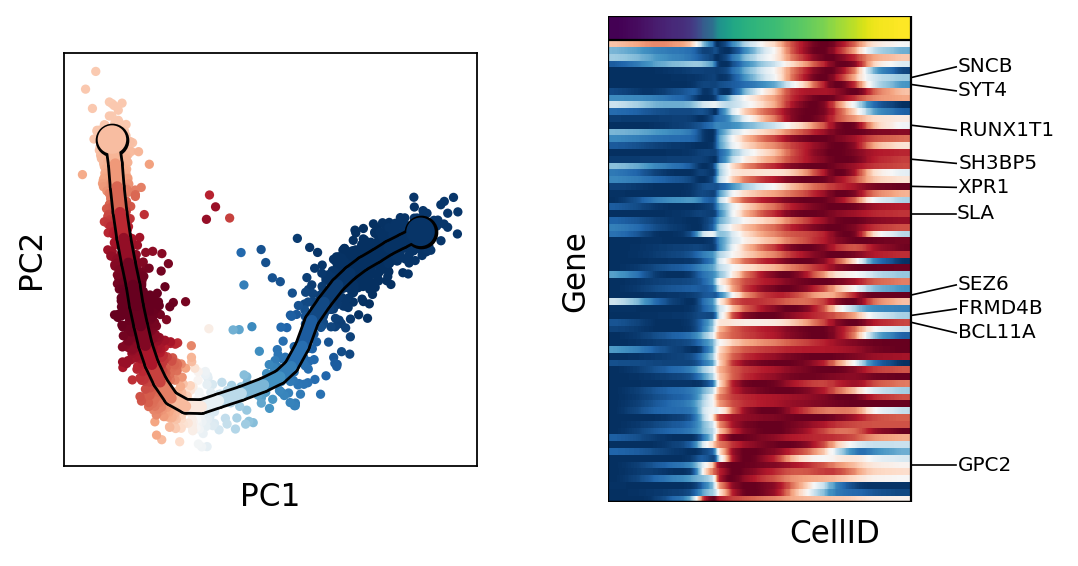

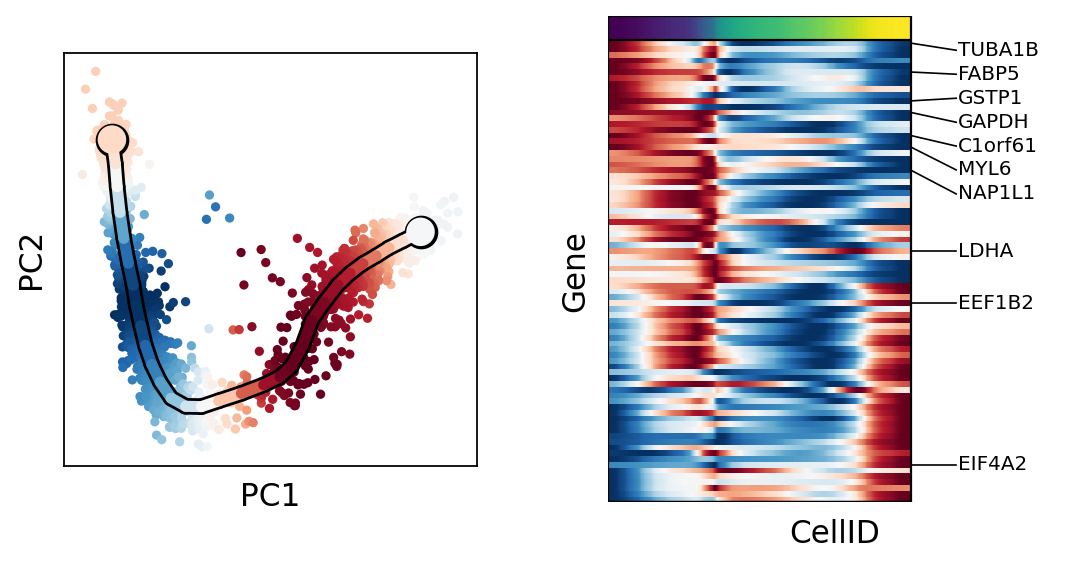

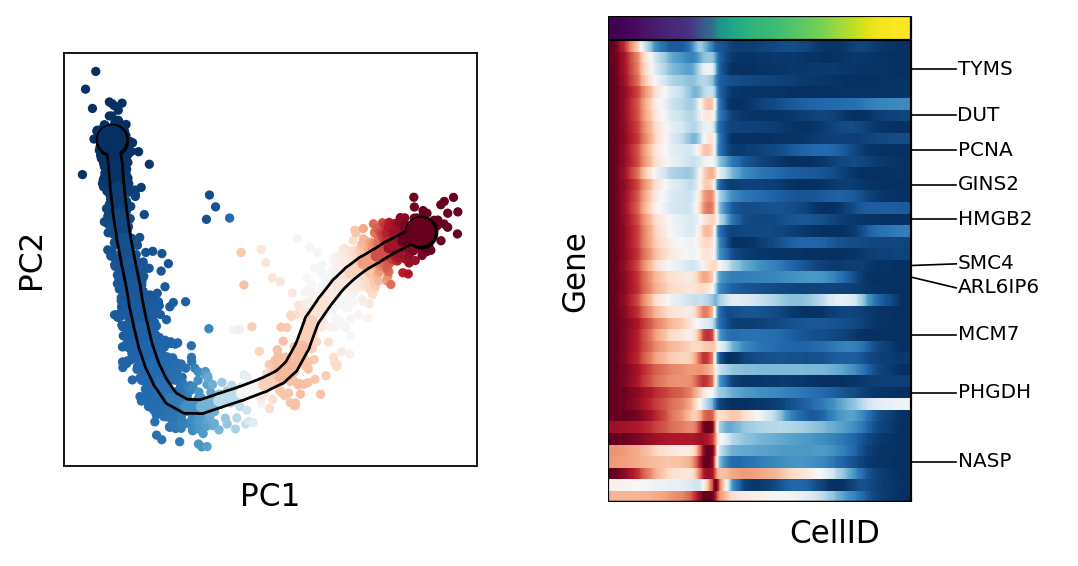

In [34]:
for c in adata.var["cluters"].unique():
    scf.pl.trends(adata,features=adata.var_names[adata.var.cluters==c],basis="pca")